<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Time-Series-RNN" data-toc-modified-id="Time-Series-RNN-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Time Series RNN</a></span><ul class="toc-item"><li><span><a href="#RNN-Models" data-toc-modified-id="RNN-Models-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>RNN Models</a></span></li></ul></li></ul></div>

# Time Series RNN




cd ~/Downloads
mkdir jena_climate
cd jena_climate
```bash
wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
unzip jena_climate_2009_2016.csv.zip
```

- https://machinelearningmastery.com/suitability-long-short-term-memory-networks-time-series-forecasting/
- https://machinelearningmastery.com/promise-recurrent-neural-networks-time-series-forecasting/

In [1]:
# !wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
# !unzip jena_climate_2009_2016.csv.zip

In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib,keras

Using TensorFlow backend.


Ethen 2019-09-24 22:04:51 

CPython 3.6.4
IPython 7.7.0

numpy 1.16.5
pandas 0.25.0
sklearn 0.21.2
matplotlib 3.1.1
keras 2.2.2


In [3]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

In [4]:
# 14 different quantities were recorded every 10 minutes
# over several years. Our goal is to build a model that takes
# as input some data from the recent past and predict the
# air temperature 24 hours in the future
df = pd.read_csv('jena_climate_2009_2016.csv')
print('dimension: ', df.shape)
df.head()

dimension:  (420551, 15)


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


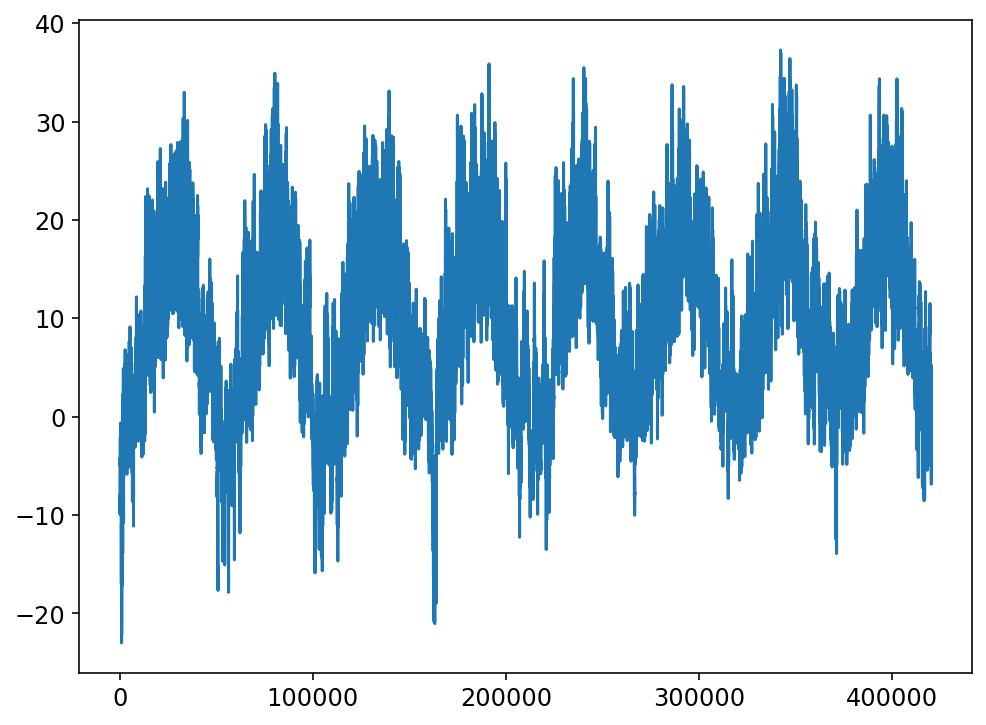

In [5]:
temperature = df[df.columns[2]]
plt.plot(range(len(temperature)), temperature)
plt.show()

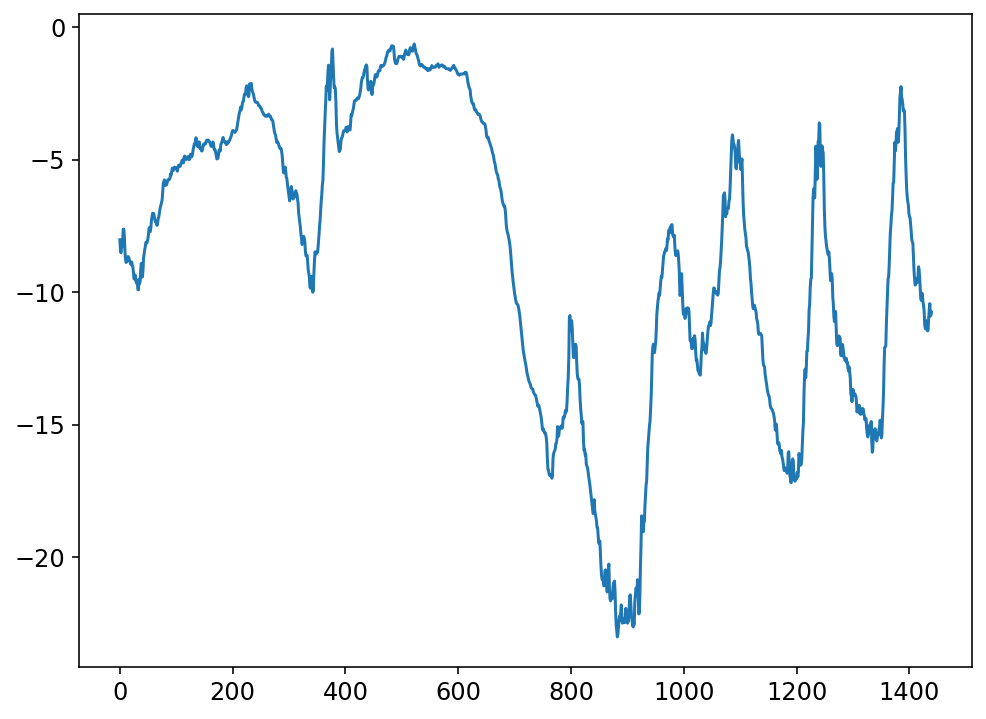

In [6]:
# we plot the first 10 days' temperature
# since the data is recorded every 10 minutes,
# we get 144 data points per day
plt.plot(range(1440), temperature[:1440])
plt.show()

The exact formulation of our problem will be the following: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every timesteps `steps`, can we predict the temperature in `delay` future timesteps?

We will use the following parameter values:

- lookback = 720, i.e. our observations will go back 5 days.
- steps = 6, i.e. our observations will be sampled at one data point per hour.
- delay = 144, i.e. our targets will be 24 hours in the future.

In [7]:
X = df[df.columns[1:]].values
X

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [8]:
train_size = 200000
X_mean = X[:train_size].mean(axis=0)
X -= X_mean
X_std = X[:train_size].std(axis=0)
X /= X_std
X

array([[ 0.90014748, -1.93135845, -1.98211036, ..., -0.72950452,
        -0.78067973, -0.27613603],
       [ 0.9060434 , -1.97541381, -2.02567   , ..., -0.93124017,
        -0.88794488, -0.46317443],
       [ 0.90132666, -1.98671006, -2.03683914, ..., -1.27614304,
        -1.26122763, -0.05330633],
       ...,
       [ 1.28927851, -1.38236094, -1.46721307, ..., -0.69696652,
        -0.67341457,  0.45008097],
       [ 1.28809932, -1.50323076, -1.58672285, ..., -0.43015486,
        -0.60476487,  0.57246412],
       [ 1.28927851, -1.56987861, -1.65150386, ..., -0.5993525 ,
        -0.690577  ,  0.10024989]])

In [8]:
label_col = 'T (degC)'
label_index = df.columns.tolist().index(label_col)
label_index

2

In [9]:
def generator(X, label_index, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(X) - delay - 1

    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            # TODO generate the batch without the full batch size ??
            if i + batch_size >= max_index:
                i = min_index + lookback
            
            # TODO, why need the min
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        # shape [batch_size, time_step, num_features]
        samples = np.zeros((len(rows), lookback // step, X.shape[1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(row - lookback, row, step)
            samples[j] = X[indices]
            targets[j] = X[row + delay, label_index]

        yield samples, targets

In [10]:
step = 6
min_index = 0
lookback = 1440
batch_size = 32

i = min_index + lookback
rows = np.arange(i, i + batch_size)
rows

array([1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450,
       1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461,
       1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470, 1471])

In [11]:
row = rows[0]
indices = range(row - lookback, row, step)
indices

range(0, 1440, 6)

In [12]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(X,
                      label_index=label_index,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(X,
                    label_index=label_index,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(X,
                     label_index=label_index,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(X) - 300001 - lookback) // batch_size

Start with a baseline, a common sense approach would be to always predict that the temperature 24 hours from now will be equal to the temperature right now.

In [13]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2951166346419421


In [14]:
0.29 * std[1]

2.567224733839344

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, X.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

metrics = None
model.compile(optimizer=RMSprop(), loss='mse', metrics=metrics)
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=5,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 9s 18ms/step - loss: 3.2447 - val_loss: 0.7805
Epoch 2/5
500/500 [==============================] - 9s 18ms/step - loss: 0.7318 - val_loss: 0.2576
Epoch 3/5
500/500 [==============================] - 9s 18ms/step - loss: 0.2714 - val_loss: 0.1674
Epoch 4/5
500/500 [==============================] - 9s 18ms/step - loss: 0.1588 - val_loss: 0.1824
Epoch 5/5
500/500 [==============================] - 9s 18ms/step - loss: 0.1305 - val_loss: 0.1710


In [40]:
score = model.evaluate_generator(test_gen, steps=test_steps)
score

51.46369723347742

In [21]:
def visualize_keras_history(history, fig_path=None):
    history = history.history
    plt.figure(figsize=(12, 8))
    plt.plot(history['loss'], label='Train')
    plt.plot(history['val_loss'], label='Test')
    plt.title('Loss History')
    plt.legend(loc='upper right', fontsize=12)
    if fig_path is not None:
        plt.savefig(fig_path)
    else:
        plt.show()

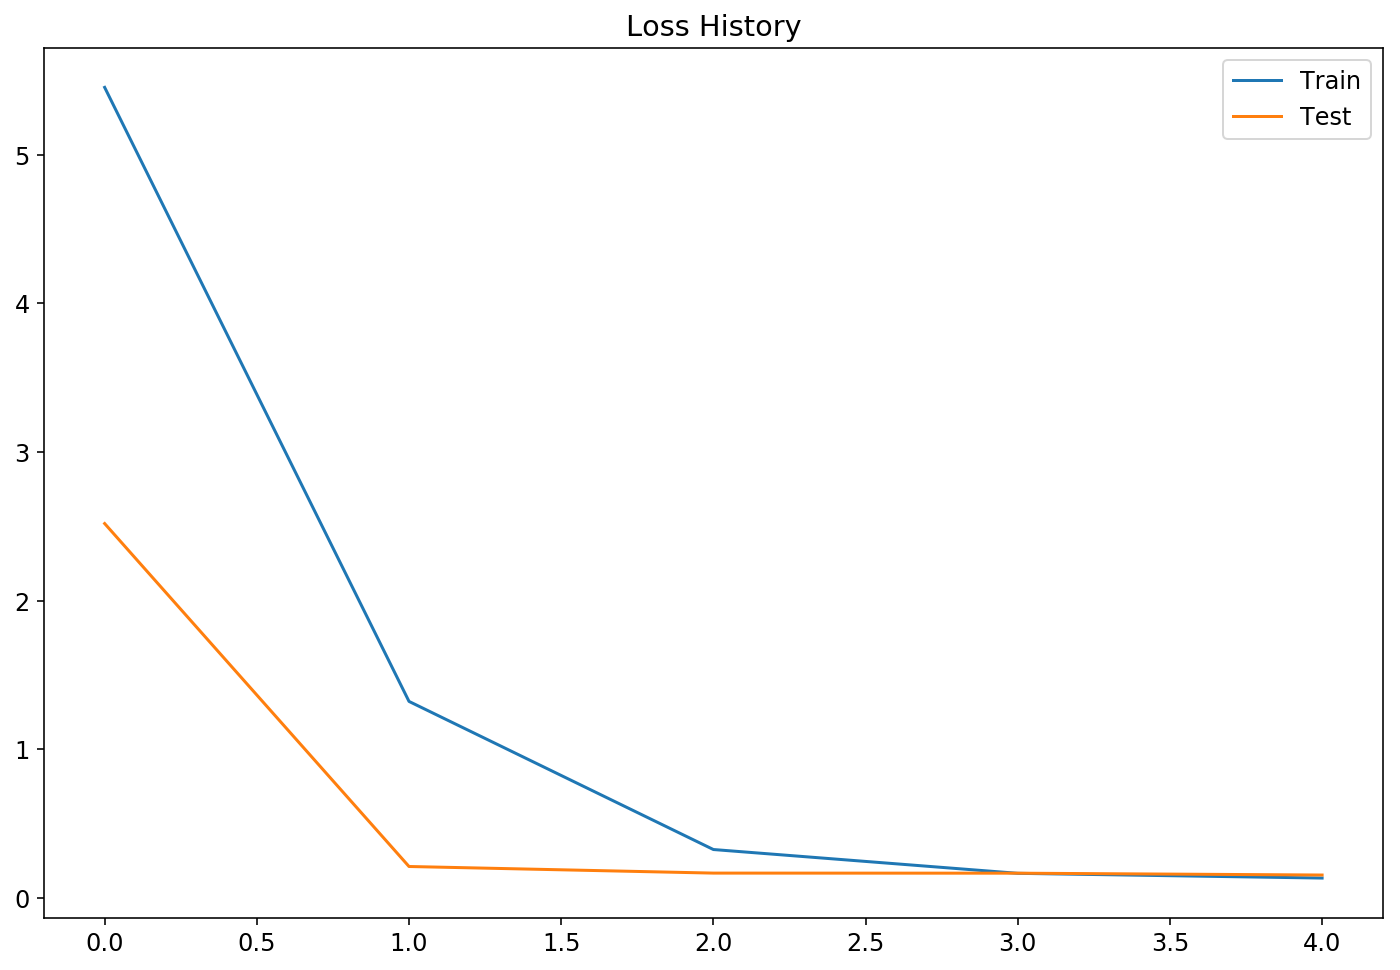

In [22]:
visualize_keras_history(history)

In [ ]:
hi

In [24]:
# from timeseries.keras_utils import KerasPipeline

# checkpoint = '/Users/mingyuliu/programming/time_series/keras/model/keras_20180705_172359/model_checkpoint'
# model = KerasPipeline(input_shape=None)
# model.load(checkpoint)
# model.history_

## RNN Models

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, X.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, X.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, X.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import os

data_dir = '/home/ubuntu/data/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

with 
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))